<a href="https://colab.research.google.com/github/MateoProjects/TFM/blob/main/Stable_diffusion_img2img_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Img2img using stable diffusion

In [1]:
#@title Instalation {display-mode: "form"} 
!pip install -qq diffusers transformers scipy ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 153 kB 5.1 MB/s 
     |████████████████████████████████| 4.7 MB 45.9 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 120 kB 86.9 MB/s 
     |████████████████████████████████| 6.6 MB 2.4 MB/s 
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [2]:
#@title Login to HuggingFace {display-mode: "form"}
from google.colab import output
output.enable_custom_widget_manager()
from huggingface_hub import notebook_login
notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [3]:
#@title Base code {display-mode: "form"}
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


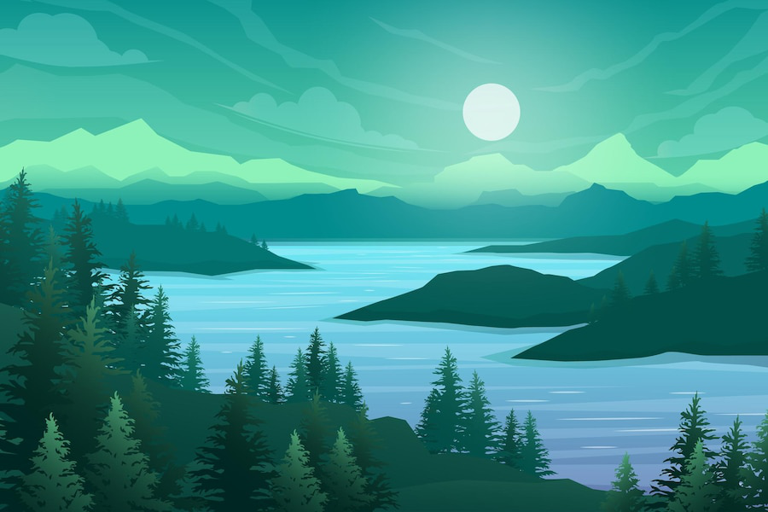

In [4]:
#@title Input image { run: "auto", display-mode: "form" }
import PIL
from PIL import Image
import numpy as np
import requests
from io import BytesIO

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.


#@markdown Insert url of image 
url = "https://img.freepik.com/free-vector/nature-scene-with-river-hills-forest-mountain-landscape-flat-cartoon-style-illustration_1150-37326.jpg?w=900&t=st=1662388972~exp=1662389572~hmac=b462299e0710f2091871e37ac84f719dbda797bc9f48ea86da6a05c34ee86ce7" #@param {type:"string"}
response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img
#@markdown **Note**: If url it's correct image will be show below. 

In [73]:
#@title Prompt for modify input image {display-mode: "form", run:"auto"}
init_image = preprocess(init_img)
prompt = "realistic landscape, trending on artstation,and a realistic moon, realistic 4k hight resolution, one bird is flying on the horizon, a women is watching the moon" #@param {type:"string"}

In [64]:
#@title Parameters for modify the output image {display-mode: "form", run:"auto"}
strength = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}
num_inference_steps = 50 #@param {type:"integer"}

guidance_scale = 7.5 #@param {type:"number"}
#@markdown **Notes**

#@markdown * **Strength** indicates how much to transform the reference `init_image`. Must be between 0 and 1.

#@markdown * **Guidance scale**  Number that indicates how images that are closely linked to the text `prompt`

#@markdown * **Num inference steps** is the number of denoising steps. More denoising steps usually lead to a higher quality image.


  0%|          | 0/38 [00:00<?, ?it/s]

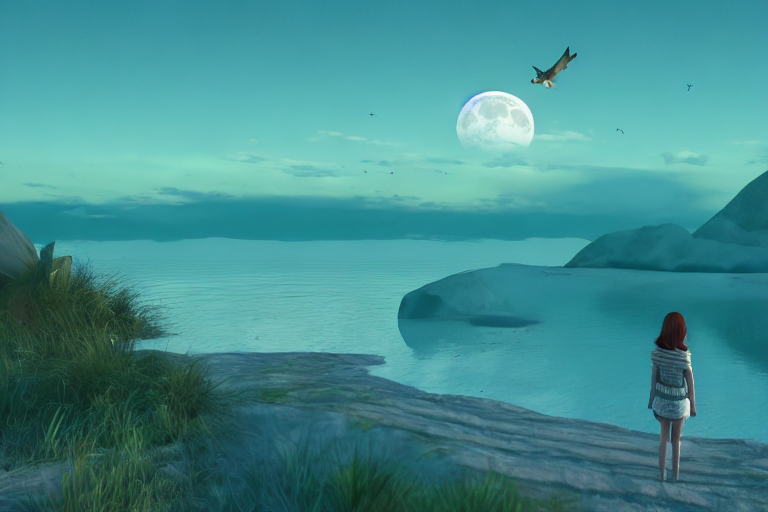

In [74]:
#@title Push play for generate image
with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, strength=strength, num_inference_steps=num_inference_steps
                  , guidance_scale=guidance_scale)["sample"]
images[0]